In [1]:
# author: Zhuocheng Sun, Yueyu Wang
# instructor: Tyler Caraza-Harter

from shapely.geometry import Point, Polygon
import shapefile as shp
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import contextily as ctx
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv("apartments.csv")
pts_col = []

df = df[df["PropertyClass"] == "Residential"]

for pt in df[["XCoord", "YCoord"]].itertuples():
    pts_col.append(Point(pt.XCoord, pt.YCoord))
df["geometry"] = pts_col
df = df[["Address", "PropertyUse", "Bedrooms", "geometry", "XCoord", "YCoord"]]

df["Bedrooms"] = df["Bedrooms"]  + 0.01 # add a small value to handle 0 bedroom cases.
df = gpd.GeoDataFrame(df)
df = df.set_crs("esri:103412")
df = df.to_crs(epsg=4326)

df = df[["Address", "PropertyUse", "Bedrooms", "geometry", "XCoord", "YCoord"]]

df.head()

/opt/anaconda3/envs/CS_HW/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (42,43,104,109,122) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Address  PropertyUse  Bedrooms                    geometry  \
0  2333 Carling Dr Unit 4  Condominium      2.01  POINT (-89.46093 43.02791)   
1  2337 Carling Dr Unit 1  Condominium      2.01  POINT (-89.46093 43.02791)   
2  2337 Carling Dr Unit 2  Condominium      2.01  POINT (-89.46093 43.02791)   
3  2337 Carling Dr Unit 3  Condominium      2.01  POINT (-89.46093 43.02791)   
4  2337 Carling Dr Unit 4  Condominium      2.01  POINT (-89.46093 43.02791)   

          XCoord         YCoord  
0  800650.916687  465776.525813  
1  800650.916687  465776.525813  
2  800650.916687  465776.525813  
3  800650.916687  465776.525813  
4  800650.916687  465776.525813

### Generally, 18 year-olds could be either 12th-grade students or college freshmen. Since we found many data entries with majorities of 18-19 year-olds, and many of those properties are located near UW campus, we think it makes more sense to regard them as college students rather than 12th-grade students. Thus, for simplicity, we only count 5 to 17 year-olds as K-12 student in this notebook.

In [26]:
census_df = pd.read_csv("census_by_block_2010/sex_age.csv")
census_df["GEO_ID"] = census_df["GEO_ID"]
census_df = census_df[["GEO_ID", "NAME", "P012001", "P012004", "P012005", "P012006", "P012028", "P012029", "P012030"]]
census_df = census_df.rename(columns = {"NAME":"Area", "P012001": "Total_people", "P012004": "5-9yrMale", "P012005": "10-14yrMale", "P012006": "15-17yrMale", "P012028": "5-9yrFemale", "P012029": "10-14yrFemale", "P012030": "15-17yrFemale"}, inplace=False)
census_df = census_df[1:]
census_df["Total_people"] = census_df["Total_people"].astype(int)
census_df["5-9yr"] = census_df["5-9yrMale"].astype(int) + census_df["5-9yrFemale"].astype(int)
census_df["10-14yr"] = census_df["10-14yrMale"].astype(int) + census_df["10-14yrFemale"].astype(int)
census_df["15-17yr"] = census_df["15-17yrMale"].astype(int) + census_df["15-17yrFemale"].astype(int)

census_df["Total_K-12_block"] = census_df["5-9yr"] + census_df["10-14yr"] + census_df["15-17yr"]
census_df = census_df[census_df["Total_K-12_block"] != 0]
census_df.head()
census_df

GEO_ID  \
1      1000000US550250001001000   
2      1000000US550250001001001   
3      1000000US550250001001002   
4      1000000US550250001001003   
5      1000000US550250001001004   
...                         ...   
12564  1000000US550259917030004   
12565  1000000US550259917030005   
12566  1000000US550259917030006   
12567  1000000US550259917030007   
12568  1000000US550259917030008   

                                                    Area  Total_people  \
1      Block 1000, Block Group 1, Census Tract 1, Dan...           170   
2      Block 1001, Block Group 1, Census Tract 1, Dan...            23   
3      Block 1002, Block Group 1, Census Tract 1, Dan...             0   
4      Block 1003, Block Group 1, Census Tract 1, Dan...            38   
5      Block 1004, Block Group 1, Census Tract 1, Dan...           141   
...                                                  ...           ...   
12564  Block 0004, Block Group 0, Census Tract 9917.0...             0   
12565  Block 0005, Block Group 0, Census Tract 9917.0...             0   
12566  Block 0006, Block Group 0, Census Tract 9917.0...             0   
12567  Block 0007, Block Group 0, Census Tract 9917.0...             0   
12568  Block 0008, Block Group 0, Census Tract 9917.0...             0   

      5-9yrMale 10-14yrMale 15-17yrMale 5-9yrFemale 10-14yrFemale  \
1             1           3           1           1             7   
2             1           0           2           0             0   
3             0           0           0           0             0   
4             1           1           0           0             1   
5             4           7           4           6             4   
...         ...         ...         ...         ...           ...   
12564         0           0           0           0             0   
12565         0           0           0           0             0   
12566         0           0           0           0             0   
12567         0           0           0           0             0   
12568         0           0           0           0             0   

      15-17yrFemale  5-9yr  10-14yr  15-17yr  Total_K-12_block  
1                 4      2       10        5                17  
2                 1      1        0        3                 4  
3                 0      0        0        0                 0  
4                 3      1        2        3                 6  
5                 3     10       11        7                28  
...             ...    ...      ...      ...               ...  
12564             0      0        0        0                 0  
12565             0      0        0        0                 0  
12566             0      0        0        0                 0  
12567             0      0        0        0                 0  
12568             0      0        0        0                 0  

[12568 rows x 13 columns]

In [27]:
# spatial join - take dataset A + dataset B = dataset AB, based on space/geographic relationship
# two datasets must have a matched CRS: coordinate reference system

dane = gpd.read_file("dane/dane.shp")
dane["GEO_ID"] = "1000000US" + dane["GEOID20"]
dane.head()

STATEFP20 COUNTYFP20 TRACTCE20 BLOCKCE20          GEOID20      NAME20  \
0        55        025    002900      2006  550250029002006  Block 2006   
1        55        025    012700      1050  550250127001050  Block 1050   
2        55        025    011404      4001  550250114044001  Block 4001   
3        55        025    000504      3015  550250005043015  Block 3015   
4        55        025    001200      4020  550250012004020  Block 4020   

  MTFCC20  UR20 UACE20 UATYPE20 FUNCSTAT20  ALAND20  AWATER20   INTPTLAT20  \
0   G5040  None   None     None          S    38858         0  +43.0614916   
1   G5040  None   None     None          S  1055458         0  +43.0221242   
2   G5040  None   None     None          S    47453         0  +43.1937131   
3   G5040  None   None     None          S     8739         0  +43.0307340   
4   G5040  None   None     None          S     7686         0  +43.0644947   

     INTPTLON20                                           geometry  \
0  -089.3182030  POLYGON ((-89.31992 43.06209, -89.31823 43.062...   
1  -089.8262570  POLYGON ((-89.83427 43.02107, -89.83427 43.021...   
2  -089.2948433  POLYGON ((-89.29664 43.19458, -89.29664 43.194...   
3  -089.5300742  POLYGON ((-89.53060 43.03119, -89.52971 43.031...   
4  -089.4064235  POLYGON ((-89.40721 43.06476, -89.40698 43.064...   

                     GEO_ID  
0  1000000US550250029002006  
1  1000000US550250127001050  
2  1000000US550250114044001  
3  1000000US550250005043015  
4  1000000US550250012004020

In [34]:
dane.to_crs(df.crs, inplace=True)
dane['area'] = dane.to_crs(epsg=3857).area/2.59e+06
block_with_apartment = gpd.sjoin(df, dane, how="left", op="within")
block_with_apartment = block_with_apartment[['Address', 'PropertyUse','Bedrooms','geometry', "XCoord", "YCoord",  'GEO_ID', 'area']]
block_with_apartment.head()

Address  PropertyUse  Bedrooms                    geometry  \
0  2333 Carling Dr Unit 4  Condominium      2.01  POINT (-89.46093 43.02791)   
1  2337 Carling Dr Unit 1  Condominium      2.01  POINT (-89.46093 43.02791)   
2  2337 Carling Dr Unit 2  Condominium      2.01  POINT (-89.46093 43.02791)   
3  2337 Carling Dr Unit 3  Condominium      2.01  POINT (-89.46093 43.02791)   
4  2337 Carling Dr Unit 4  Condominium      2.01  POINT (-89.46093 43.02791)   

          XCoord         YCoord                    GEO_ID     area  
0  800650.916687  465776.525813  1000000US550250006002003  0.04846  
1  800650.916687  465776.525813  1000000US550250006002003  0.04846  
2  800650.916687  465776.525813  1000000US550250006002003  0.04846  
3  800650.916687  465776.525813  1000000US550250006002003  0.04846  
4  800650.916687  465776.525813  1000000US550250006002003  0.04846

#### We now have census data for each block in Madison. To estimate the number of K-12 students in each property, we think using the formula: K-12_est = (number of bedrooms in a property) * (number of K-12 students in the block)/ (number of bedrooms in the block) is a good approach for now.

In [35]:
merged = pd.merge(block_with_apartment, census_df, on="GEO_ID")
merged = merged[["Area","Address", "PropertyUse", "Bedrooms", "geometry", "XCoord", "YCoord", "Total_people", "Total_K-12_block", "GEO_ID", "area"]]
merged['BlockBedrooms'] = merged.groupby(['GEO_ID']).Bedrooms.transform('sum')

In [36]:
merged["K12_est"] = merged["Total_K-12_block"] * merged["Bedrooms"] / merged["BlockBedrooms"]
K12_df = merged

In [37]:
lake_df = gpd.read_file("lakes.zip")

(-89.55, -89.273, 43.0125, 43.15)

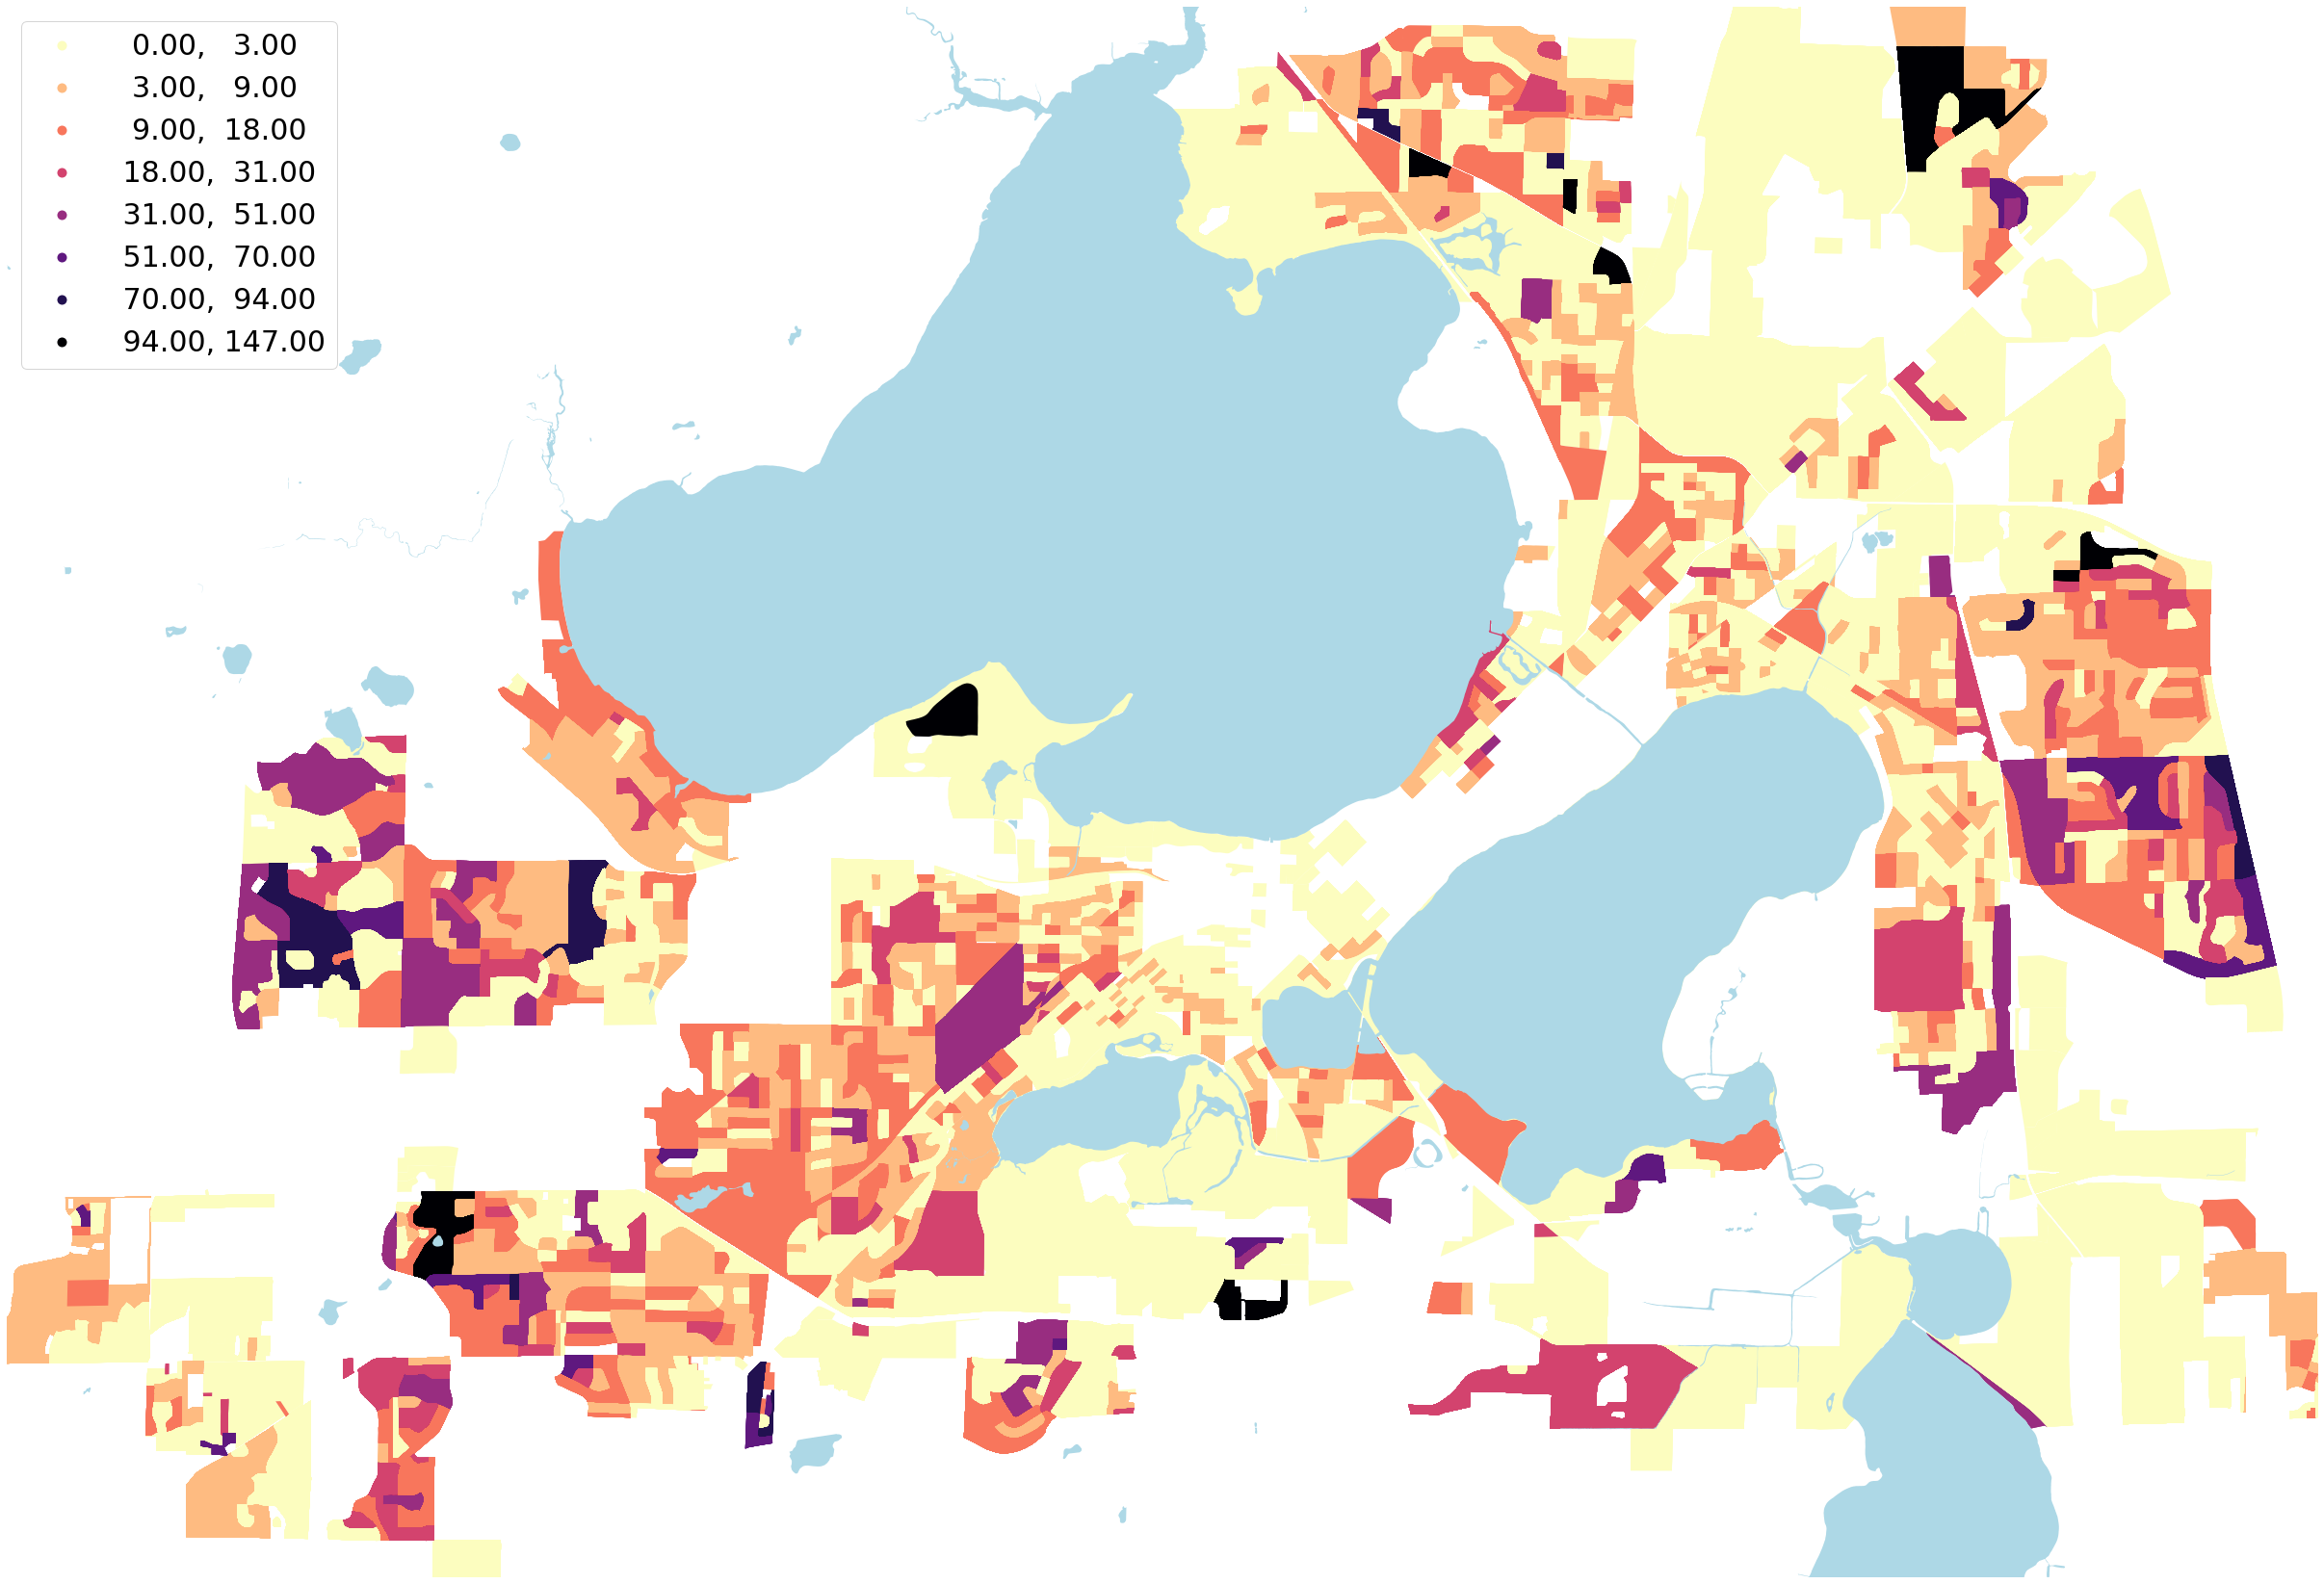

In [38]:
madison = gpd.sjoin(K12_df, dane, how="right", op="within")
madison = madison[madison["Total_K-12_block"] >= 0]
ax = madison.plot(figsize = (50, 30), legend=True, scheme = 'NaturalBreaks', k = 8, column='Total_K-12_block', cmap = 'magma_r', legend_kwds={'fontsize':30, 'loc': 'upper left'})
lake_df.plot(ax=ax,color="lightblue")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_ylim([43.0125, 43.150])
ax.set_xlim([-89.55, -89.273])
ax.axis('off')
# ax.set_title("Property in Madison", fontsize)


In [40]:
tmp = madison.drop_duplicates("GEO_ID_x")
tmp["Total_people"].sum()

121870.0

## Linear Regression part

In [18]:
Condominium_bedroom_block = merged[(merged["PropertyUse"] == "Condominium") | (merged["PropertyUse"] == "2 unit Apartment")
                                   | (merged["PropertyUse"] == "3 unit Apartment") | (merged["PropertyUse"] == "4 unit Apartment")
                                   | (merged["PropertyUse"] == "5 unit Apartment") | (merged["PropertyUse"] == "6 unit Apartment")
                                   | (merged["PropertyUse"] == "7 unit Apartment")]
Condominium_bedroom_block = Condominium_bedroom_block[["Area", "Address", "PropertyUse", "Bedrooms", "Total_K-12_block", "GEO_ID", "BlockBedrooms", "geometry", "area"]]
Condominium_bedroom_block["Apartment_bedroom"] = Condominium_bedroom_block.groupby(['GEO_ID']).Bedrooms.transform('sum')
Condominium_bedroom_block["other_bedroom"] = Condominium_bedroom_block["BlockBedrooms"] - Condominium_bedroom_block["Apartment_bedroom"]
Condominium_bedroom_block = Condominium_bedroom_block.drop_duplicates("GEO_ID")
Condominium_bedroom_block = Condominium_bedroom_block[["GEO_ID", "Apartment_bedroom", "other_bedroom"]]
total_bedroom_block = merged[["GEO_ID", "BlockBedrooms", "Total_K-12_block", "geometry", "area"]]
total_bedroom_block = total_bedroom_block.drop_duplicates("GEO_ID")
result = total_bedroom_block.merge(Condominium_bedroom_block, on="GEO_ID", how = "outer")
result["Apartment_bedroom"].fillna(0, inplace=True)
result["other_bedroom"].fillna(result["BlockBedrooms"], inplace=True)
result

14801

Text(0.5, 1.0, 'Linear Regression Coefficients')

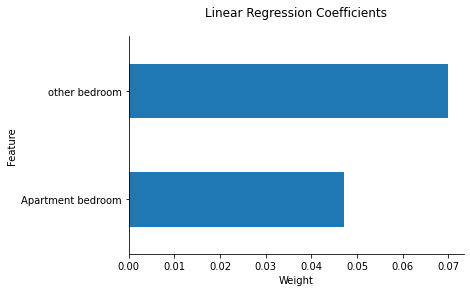

In [11]:
xcol = ["Apartment_bedroom", "other_bedroom"]
model1 = Pipeline([
            ("lr", LinearRegression())
        ])
model1.fit(result[xcol], result["Total_K-12_block"])

idx = [t.replace("_", " ") for t in xcol]
ax3 = pd.Series(model1["lr"].coef_, index=idx).plot.barh()
ax3.set_xlabel("Weight")
ax3.set_ylabel("Feature")
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.set_title("Linear Regression Coefficients", pad=20)

## Top 20 apartments table

In [12]:
# sort by the number of K-12 children estimation grouped by Point.
K12_df["K-12_by_point"] = K12_df.groupby(by=["XCoord", "YCoord"])["K12_est"].transform('sum')
point_order = K12_df.sort_values(by=['K-12_by_point'], ascending=False)

In [13]:
Top_20 = K12_df
Top_20 = Top_20[(Top_20["PropertyUse"] == "Condominium") | (Top_20["PropertyUse"] == "2 unit Apartment")
                                   | (Top_20["PropertyUse"] == "3 unit Apartment") | (Top_20["PropertyUse"] == "4 unit Apartment")
                                   | (Top_20["PropertyUse"] == "5 unit Apartment") | (Top_20["PropertyUse"] == "6 unit Apartment")
                                   | (Top_20["PropertyUse"] == "7 unit Apartment")]
Top_20["Apartment_bedrooms"] = Top_20.groupby(["XCoord", "YCoord"]).Bedrooms.transform(sum)
Top_20 = Top_20.drop_duplicates("geometry")
Top_20 = Top_20.sort_values(by=['K-12_by_point'], ascending=False)
Top_20 = Top_20[:20]
Top_20 = Top_20[["Area", "Address", "geometry", "Apartment_bedrooms", "K-12_by_point"]]
Top_20.to_csv("Top20_Apartments.csv", index = False)
Top_20

/opt/anaconda3/envs/CS_HW/lib/python3.8/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


Area  \
26865  Block 2008, Block Group 2, Census Tract 2.05, ...   
0      Block 2003, Block Group 2, Census Tract 6, Dan...   
14067  Block 2002, Block Group 2, Census Tract 14.01,...   
36155  Block 2010, Block Group 2, Census Tract 26.02,...   
40     Block 2003, Block Group 2, Census Tract 6, Dan...   
14040  Block 2002, Block Group 2, Census Tract 14.01,...   
30246  Block 3004, Block Group 3, Census Tract 24.01,...   
37391  Block 2007, Block Group 2, Census Tract 9.01, ...   
27683  Block 2010, Block Group 2, Census Tract 2.02, ...   
37279  Block 3000, Block Group 3, Census Tract 5.04, ...   
27736  Block 2005, Block Group 2, Census Tract 2.02, ...   
37136  Block 3026, Block Group 3, Census Tract 14.02,...   
37173  Block 3012, Block Group 3, Census Tract 14.02,...   
36544  Block 3019, Block Group 3, Census Tract 5.04, ...   
33458  Block 2005, Block Group 2, Census Tract 6, Dan...   
36802  Block 1015, Block Group 1, Census Tract 26.03,...   
5848   Block 1025, Block Group 1, Census Tract 105.01...   
6214   Block 3000, Block Group 3, Census Tract 29, Da...   
37511  Block 2001, Block Group 2, Census Tract 6, Dan...   
33038  Block 2010, Block Group 2, Census Tract 24.02,...   

                         Address                    geometry  \
26865           7318 Old Sauk Rd  POINT (-89.51222 43.07606)   
0         2333 Carling Dr Unit 4  POINT (-89.46093 43.02791)   
14067       1141 Petra Pl Unit 2  POINT (-89.40292 43.03639)   
36155    4310 Melody Ln Unit 101  POINT (-89.30960 43.13227)   
40         2354 Allied Dr Unit 2  POINT (-89.46006 43.02748)   
14040       1174 Petra Pl Unit 3  POINT (-89.40245 43.03745)   
30246            1633 Wheeler Rd  POINT (-89.36492 43.14607)   
37391   1802 Monroe St Unit P625  POINT (-89.41744 43.06516)   
27683   301 Nautilus Dr Unit CDM  POINT (-89.48887 43.06211)   
37279  7201 Mid Town Rd Unit 212  POINT (-89.50923 43.03088)   
27736           6604 Offshore Dr  POINT (-89.49687 43.06333)   
37136               2040 Post Rd  POINT (-89.41624 43.02716)   
37173       2233 Luann Ln Unit 1  POINT (-89.41683 43.03196)   
36544           8325 Mid Town Rd  POINT (-89.53080 43.03073)   
33458  4717 Crescent Rd Unit CDM  POINT (-89.45905 43.02449)   
36802        726 Mesta Ln Unit 2  POINT (-89.29676 43.10822)   
5848      6137 Quiet Canyon Loop  POINT (-89.27379 43.02710)   
6214     1313 Tompkins Dr Unit D  POINT (-89.31034 43.05766)   
37511           4706 Jenewein Rd  POINT (-89.45869 43.02920)   
33038             312 East Bluff  POINT (-89.36489 43.13251)   

       Apartment_bedrooms  K-12_by_point  
26865              298.29      68.000000  
0                   77.39      43.137021  
14067               64.33      40.073314  
36155              465.89      36.000000  
40                  64.33      35.857405  
14040               48.25      30.056543  
30246              335.94      27.000000  
37391               95.19      24.000000  
27683               24.09      21.249089  
37279              124.67      21.000000  
27736              249.97      20.069378  
37136               56.29      20.000000  
37173               96.49      20.000000  
36544                4.03      18.952970  
33458                4.03      17.303671  
36802               48.25      16.996477  
5848                86.33      16.000000  
6214               156.71      14.776051  
37511               12.01      14.000000  
33038              440.77      13.419699

## Plots

#### cumulative children live in apartments

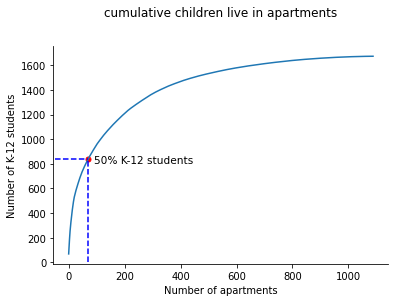

In [14]:
Buildings = K12_df[["GEO_ID", "PropertyUse", "geometry", "Area", "K-12_by_point"]]
Buildings = Buildings[(Buildings["PropertyUse"] == "Condominium") | (Buildings["PropertyUse"] == "2 unit Apartment")
                                   | (Buildings["PropertyUse"] == "3 unit Apartment") | (Buildings["PropertyUse"] == "4 unit Apartment")
                                   | (Buildings["PropertyUse"] == "5 unit Apartment") | (Buildings["PropertyUse"] == "6 unit Apartment")
                                   | (Buildings["PropertyUse"] == "7 unit Apartment")]
Buildings = Buildings.drop_duplicates("geometry")
Buildings = Buildings.sort_values(by=['K-12_by_point'], ascending=False)
K12_data = np.array(Buildings["K-12_by_point"].tolist())
cumulative = pd.DataFrame(K12_data.cumsum())
plt.plot(cumulative)
plt.axis('tight')
plt.title("cumulative children live in apartments", pad=30)
plt.xlabel("Number of apartments")
plt.ylabel("Number of K-12 students")
plt.scatter(69, 1673.593704/2, s=25, c='r')
plt.plot([-50, 69], [1673.593704/2, 1673.593704/2], c='b', linestyle='--')
plt.plot([69, 69], [0, 1673.593704/2], c='b', linestyle='--')
plt.text(69+200, 1673.593704/2-50, '50% K-12 students', ha='center', va='bottom', fontsize=10.5)  # horizontal alignment
ax = plt.gca()
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
plt.show()


In [15]:
cumulative.describe()

0
count  1089.000000
mean   1430.661254
std     300.417175
min      68.000000
25%    1329.582694
50%    1555.284418
75%    1642.902919
max    1673.593704

## Use the linear regression coef to improve the estimate


In [16]:
total = model1["lr"].coef_[0] + model1["lr"].coef_[1]
apt_pro = model1["lr"].coef_[0]
house_pro = model1["lr"].coef_[1]

result["K12_in_apt"] = result["Total_K-12_block"] / (result["other_bedroom"] + result["Apartment_bedroom"] * (apt_pro/house_pro)) * (result["Apartment_bedroom"] * (apt_pro/house_pro))
result["K12_in_other"] = result["Total_K-12_block"] - result["K12_in_apt"]
result['apt_density'] = result['K12_in_apt'] / result['area']
result['other_density'] = result['K12_in_other'] / result['area']
result.head()

GEO_ID  BlockBedrooms  Total_K-12_block  \
0  1000000US550250006002003         141.73                79   
1  1000000US550250005012004           3.01                 2   
2  1000000US550250006003021           9.04                 2   
3  1000000US550250006002007          27.17                83   
4  1000000US550250014022008         116.30                37   

                     geometry      area  Apartment_bedroom  other_bedroom  \
0  POINT (-89.46093 43.02791)  0.048460             141.72           0.01   
1  POINT (-89.46611 43.02981)  0.001369               0.00           3.01   
2  POINT (-89.44750 43.02810)  0.003821               0.00           9.04   
3  POINT (-89.45832 43.02627)  0.017482               0.00          27.17   
4  POINT (-89.42949 43.02727)  0.058471               0.00         116.30   

   K12_in_apt  K12_in_other  apt_density  other_density  
0   78.991733      0.008267  1630.045071       0.170589  
1    0.000000      2.000000     0.000000    1460.783809  
2    0.000000      2.000000     0.000000     523.439331  
3    0.000000     83.000000     0.000000    4747.812087  
4    0.000000     37.000000     0.000000     632.786986

<AxesSubplot:>

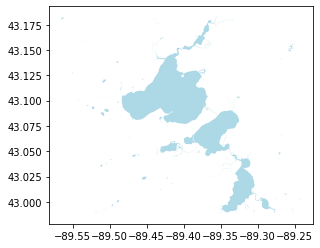

In [17]:
lake_df = gpd.read_file("lakes.zip")
lake_df.plot(color="lightblue")

### The density plot of k12 in apartment

(-89.55, -89.273, 43.0125, 43.15)

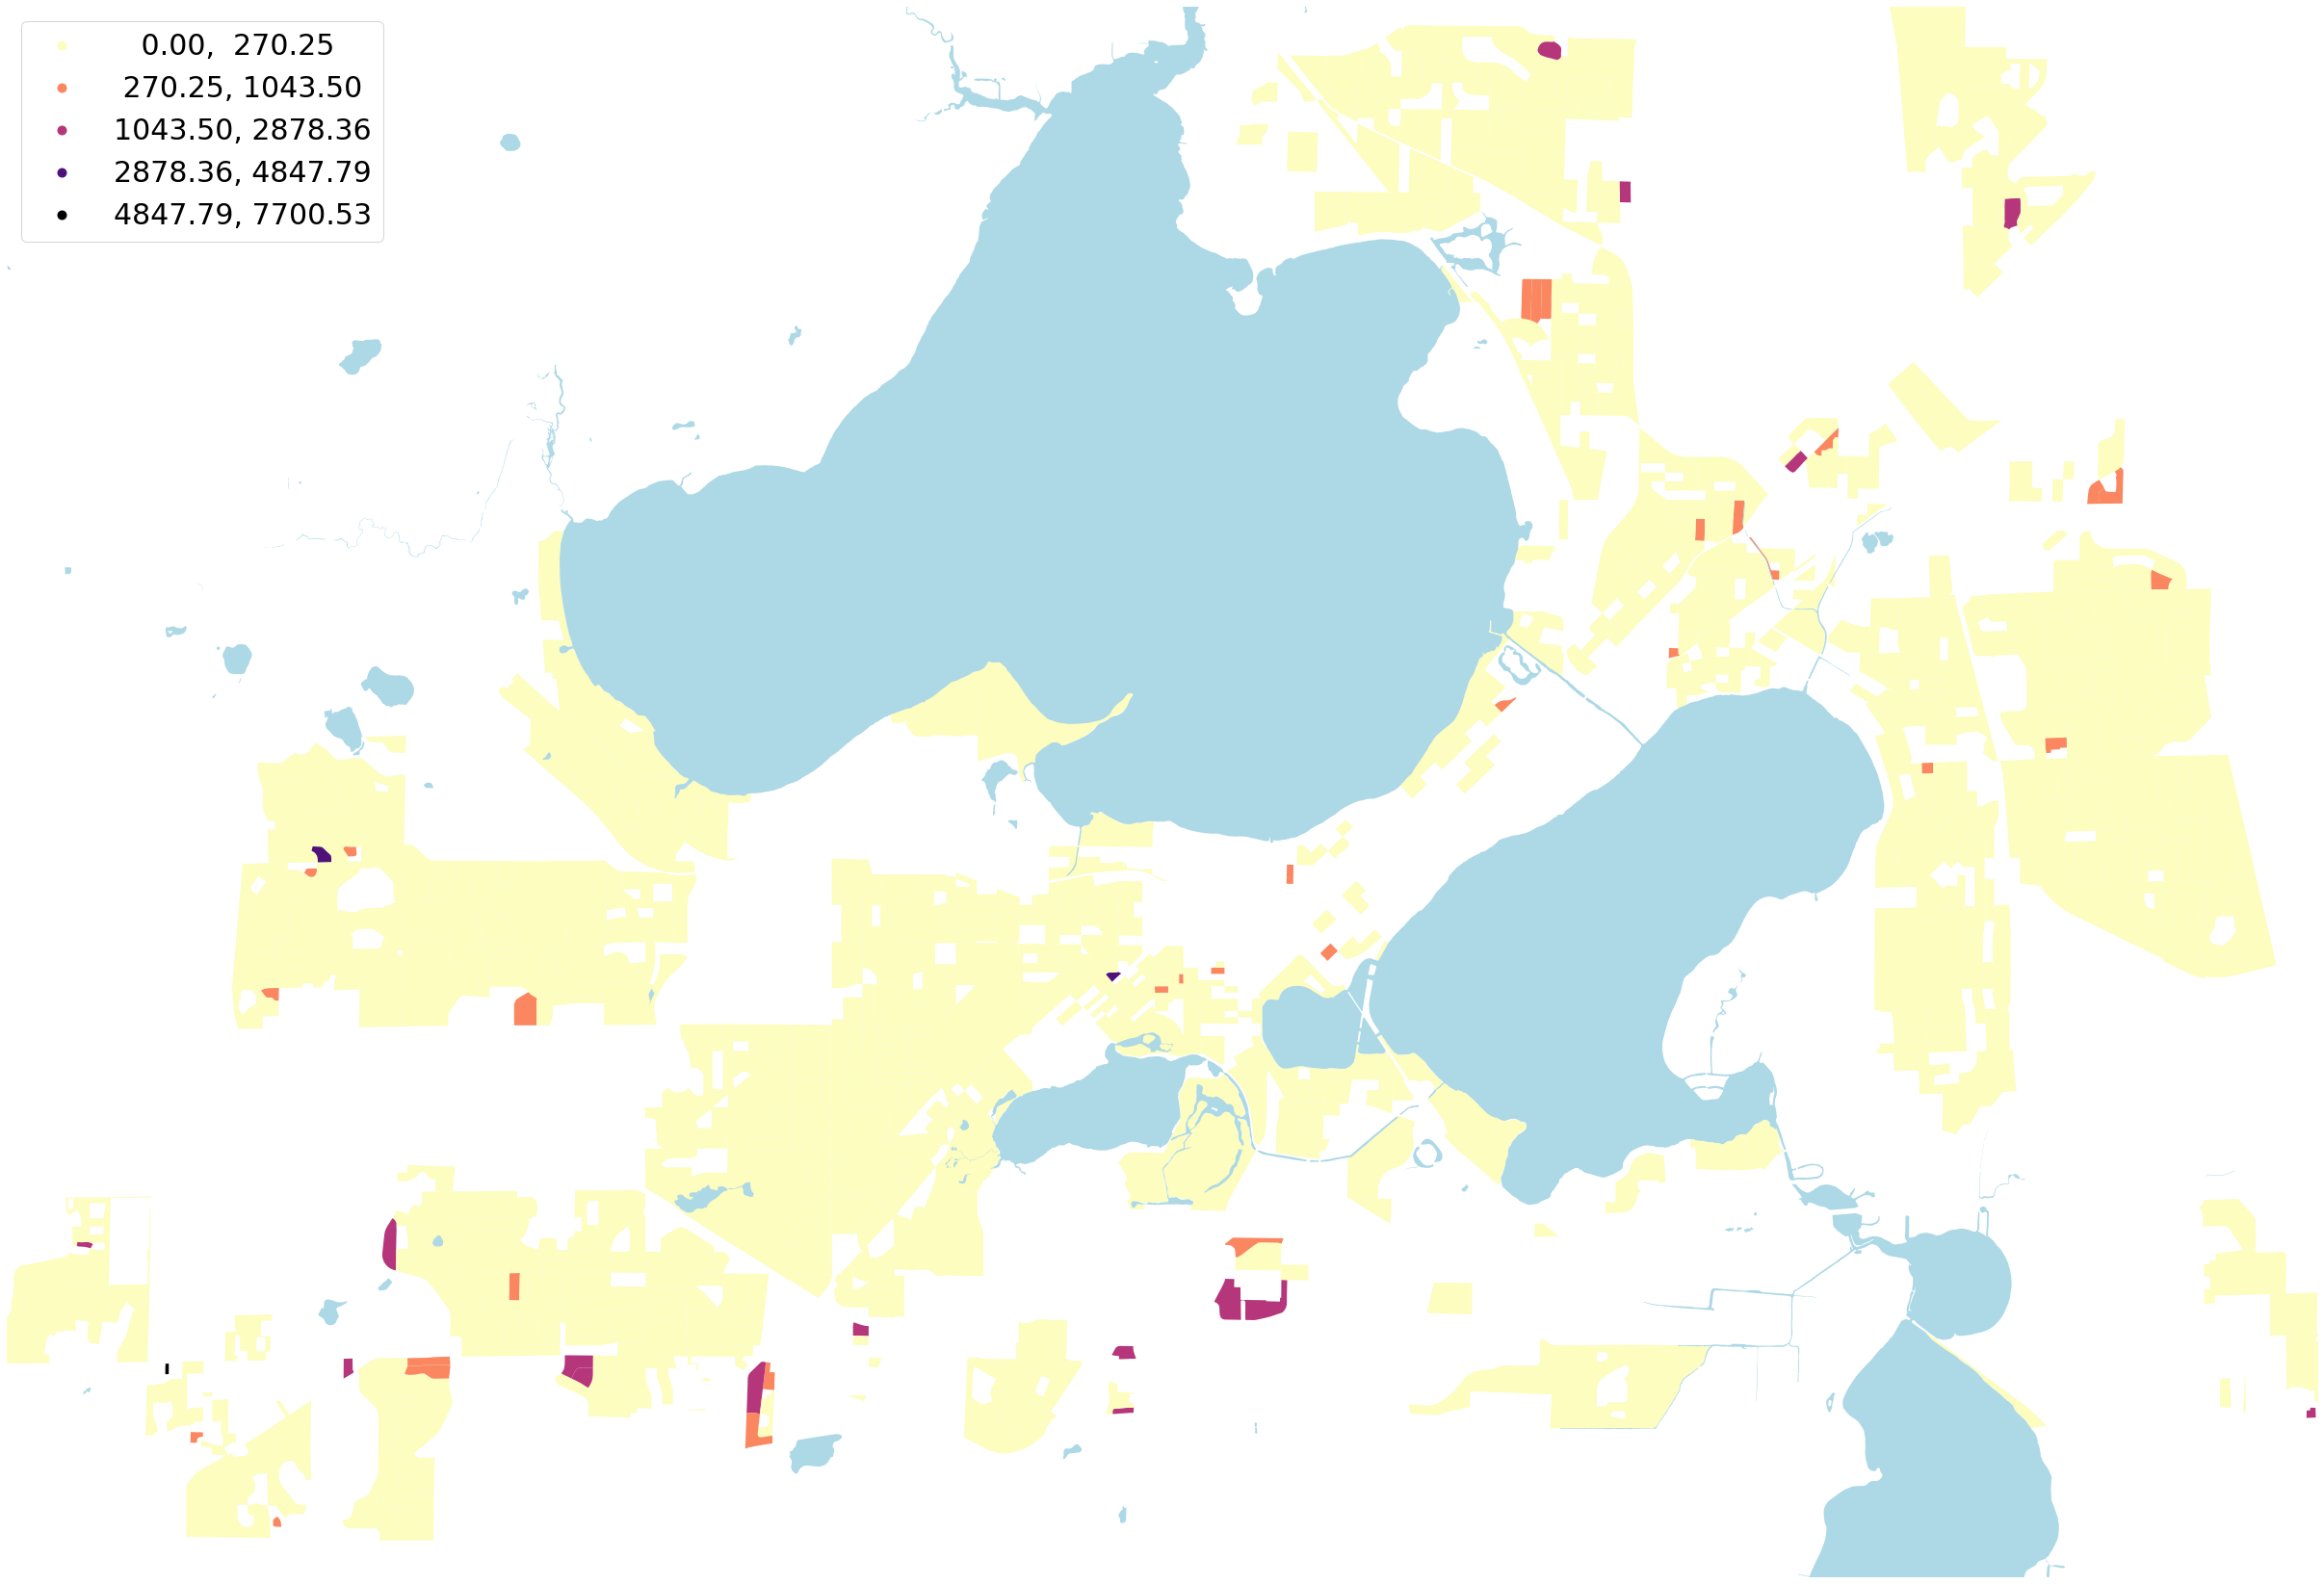

In [18]:
result = gpd.GeoDataFrame(result)
lake_df = lake_df.to_crs(result.crs)
apartment_madison = gpd.sjoin(result, dane, how="right", op="within")
ax = apartment_madison.plot(figsize = (50, 30), legend=True, scheme = 'NaturalBreaks', k = 5, column='apt_density', cmap = 'magma_r', legend_kwds={'fontsize':30, 'loc': 'upper left'})
lake_df.plot(ax=ax,color="lightblue")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_ylim([43.0125, 43.150])
ax.set_xlim([-89.55, -89.273])
ax.axis('off')

### The density plot of k12 in other house

(-89.55, -89.273, 43.0125, 43.15)

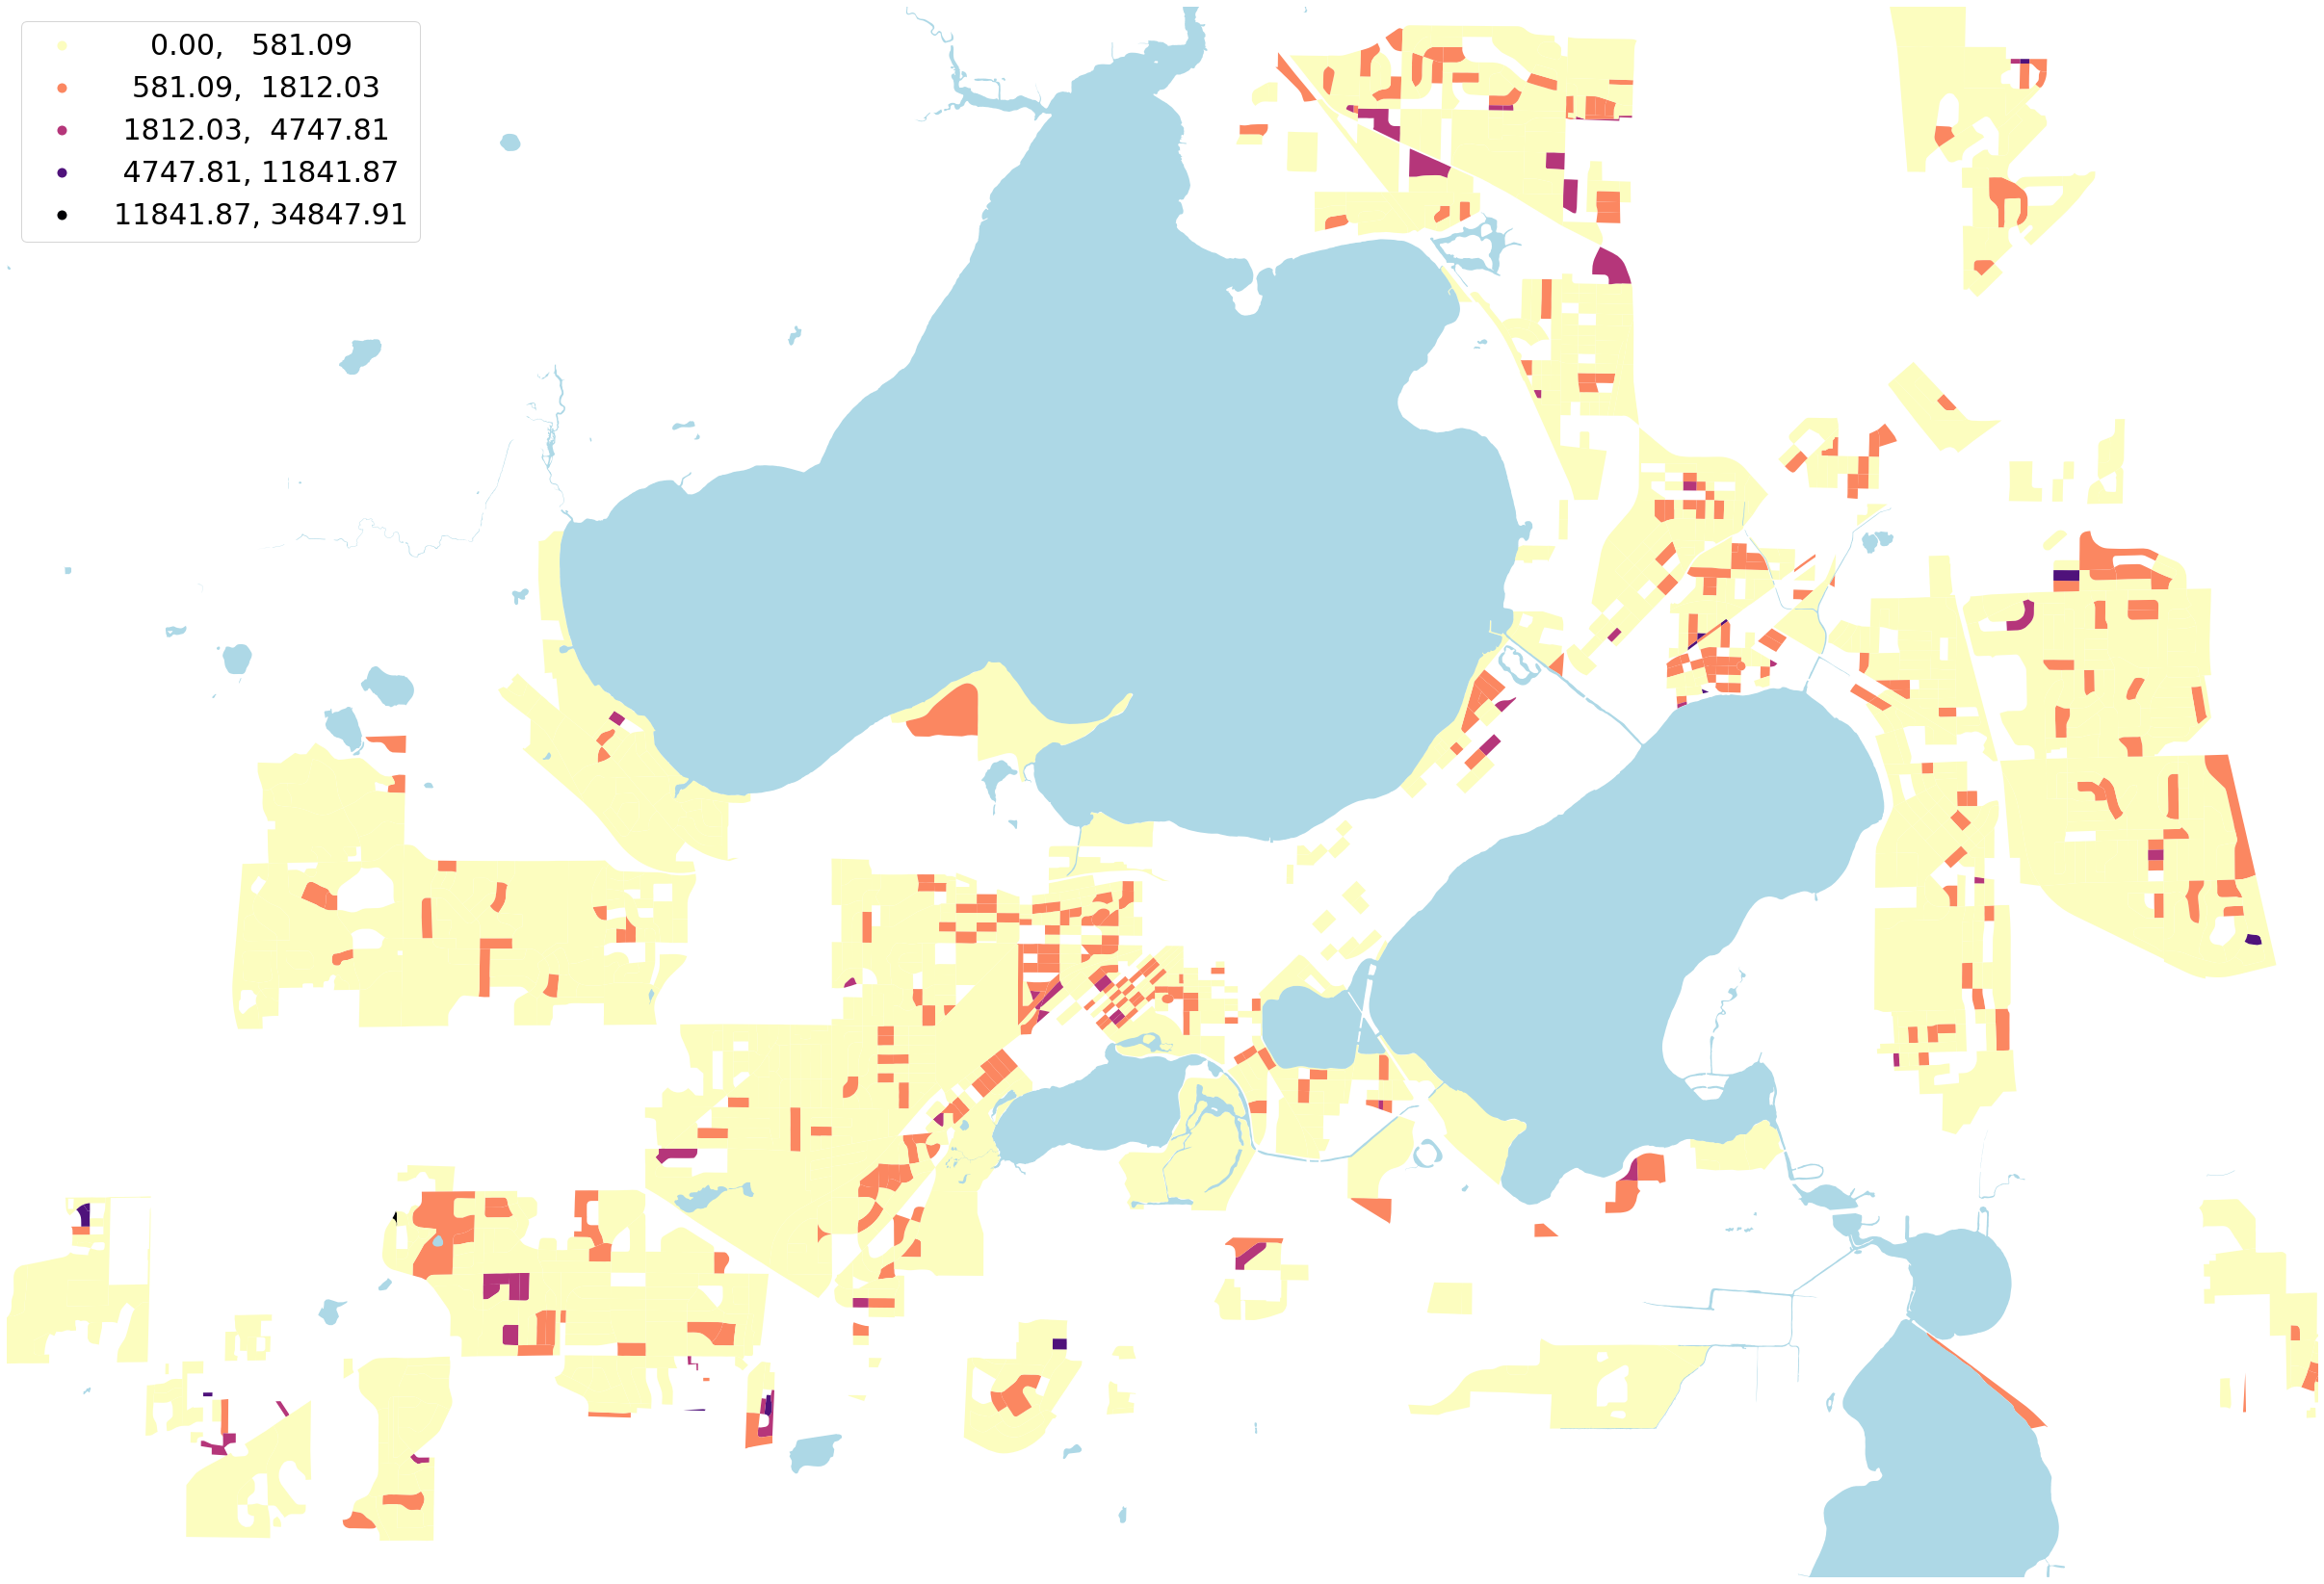

In [19]:
result = gpd.GeoDataFrame(result)
apartment_madison = gpd.sjoin(result, dane, how="right", op="within")
ax = apartment_madison.plot(figsize = (50, 30), legend=True, scheme = 'NaturalBreaks', k = 5, column='other_density', cmap = 'magma_r', legend_kwds={'fontsize':30, 'loc': 'upper left'})
lake_df.plot(ax=ax,color="lightblue")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_ylim([43.0125, 43.150])
ax.set_xlim([-89.55, -89.273])
ax.axis('off')

## The density plot of k12 in each blocks

(-89.55, -89.273, 43.0125, 43.15)

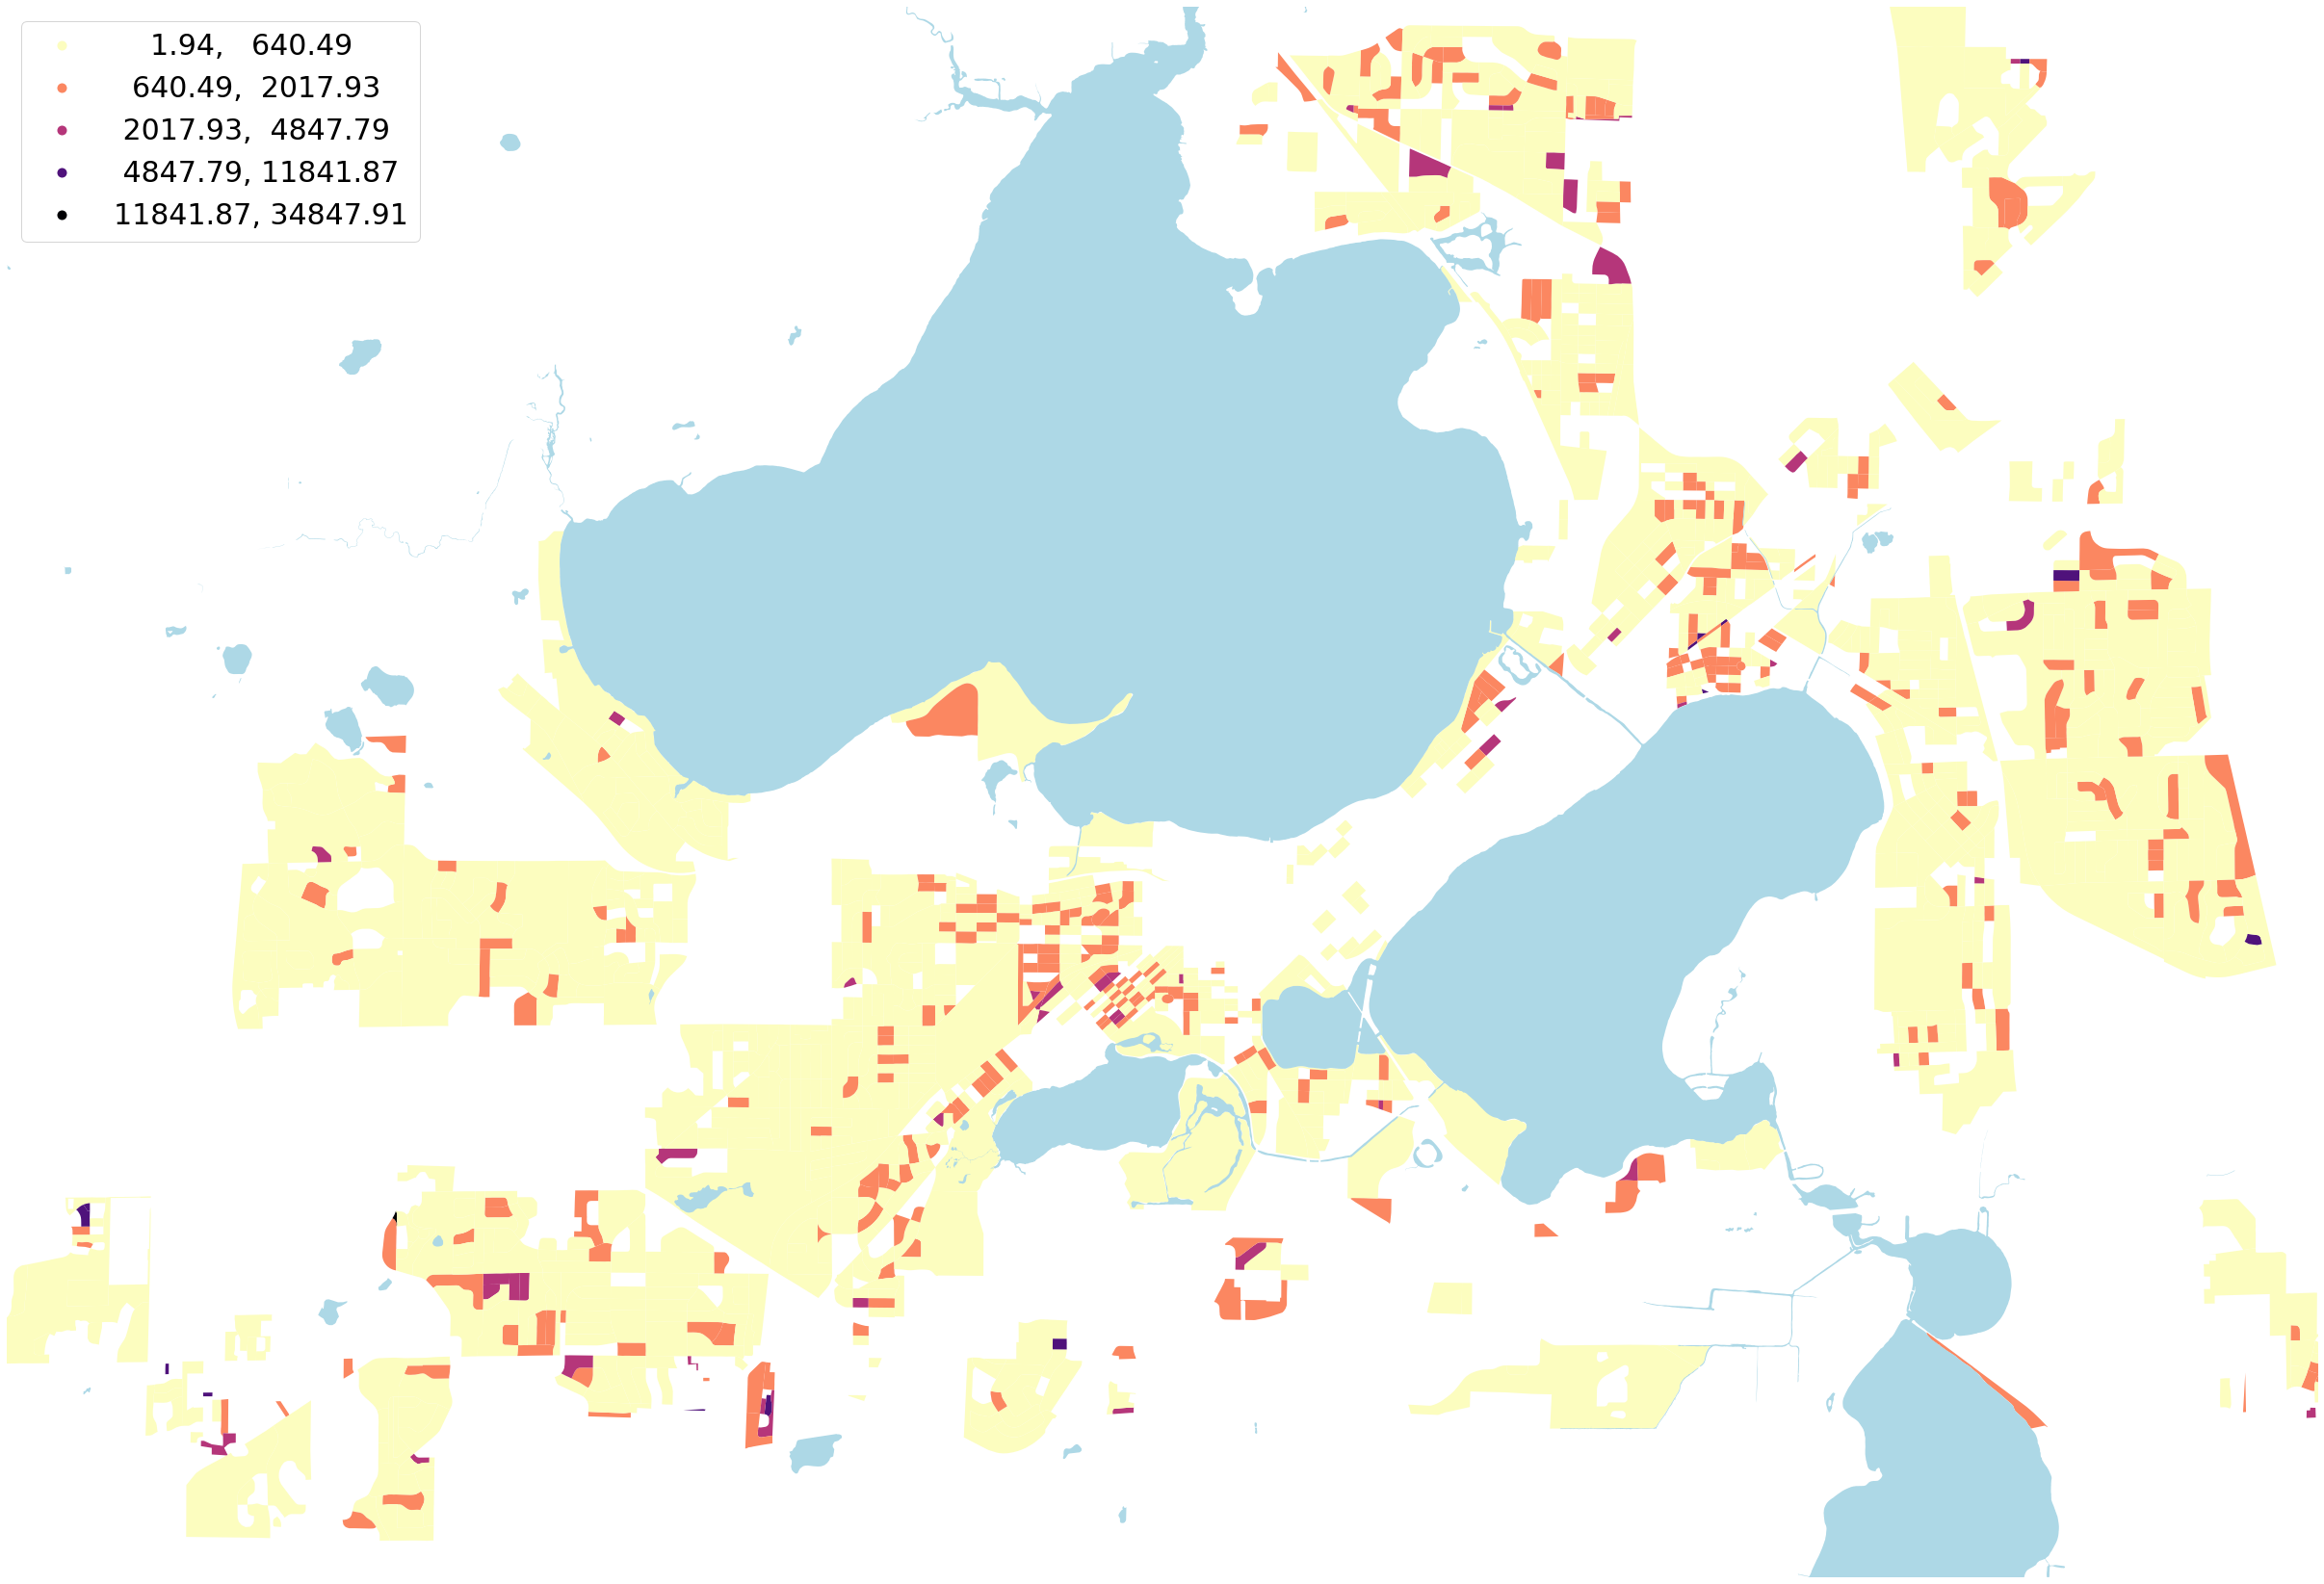

In [20]:
result["block_density"] = result['Total_K-12_block'] / result['area']
result = gpd.GeoDataFrame(result)
apartment_madison = gpd.sjoin(result, dane, how="right", op="within")
ax = apartment_madison.plot(figsize = (50, 30), legend=True, scheme = 'NaturalBreaks', k = 5, column='block_density', cmap = 'magma_r', legend_kwds={'fontsize':30, 'loc': 'upper left'})
lake_df.plot(ax=ax,color="lightblue")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_ylim([43.0125, 43.150])
ax.set_xlim([-89.55, -89.273])
ax.axis('off')

## Properties That May Have K-12 Kids (by estimation)

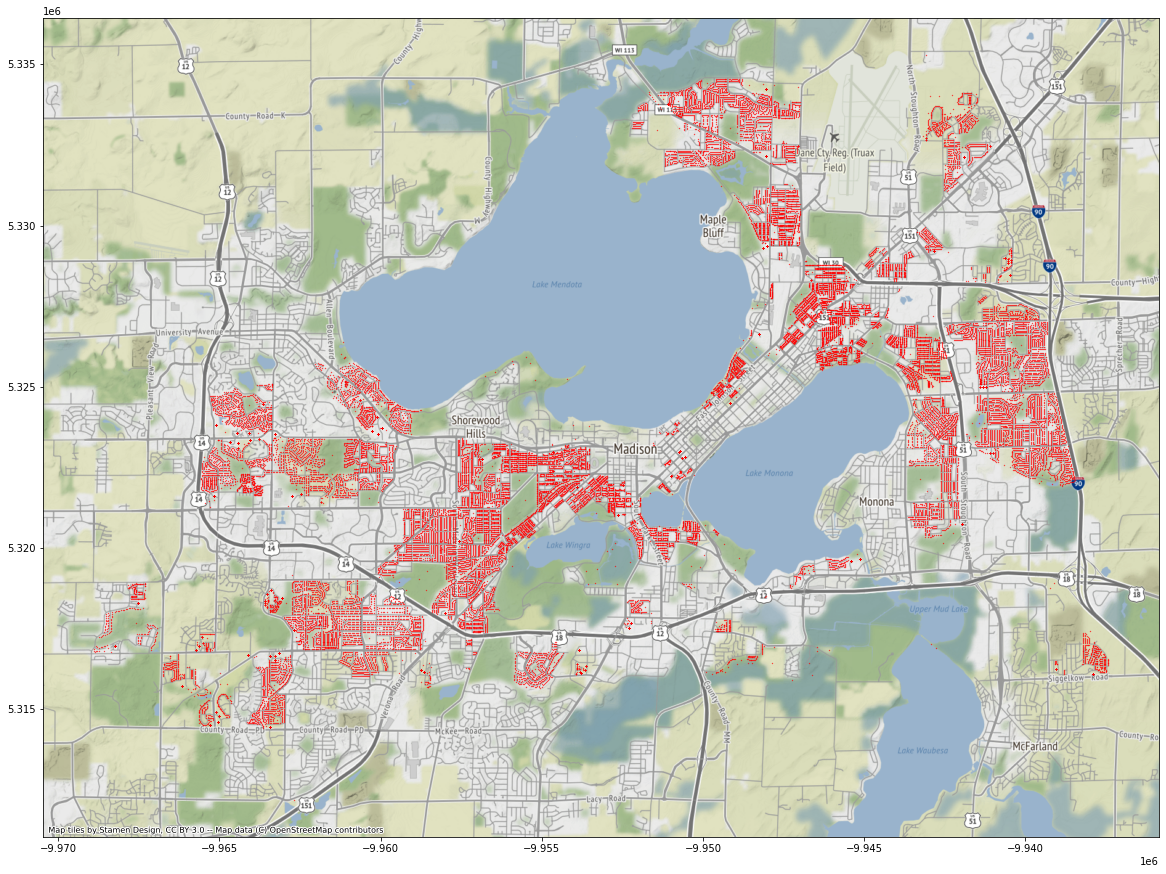

In [21]:
K12_df = K12_df.to_crs(epsg=3857)
ax_k12 = K12_df.plot(markersize=0.1, figsize=(20,20), color="red")
ax2 = ctx.add_basemap(ax_k12)

## Makersize Represented by the Number of K-12 Kids (by estimation)

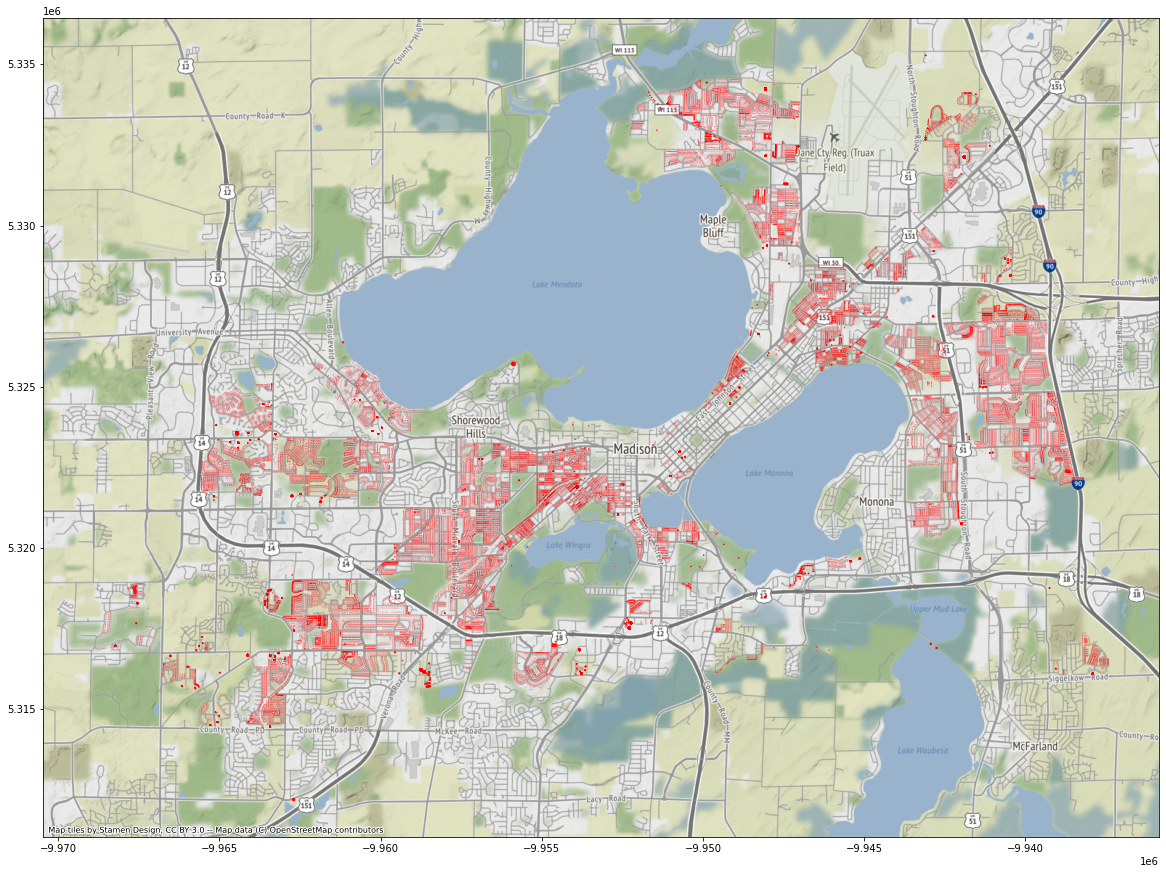

In [22]:
ax_k12_with_size = K12_df.plot(markersize=K12_df["K-12_by_point"]/10, figsize=(20,20), color="red")
ax3 = ctx.add_basemap(ax_k12_with_size)

## All Residential Properties in City of Madison

(-89.55, -89.273, 43.0125, 43.15)

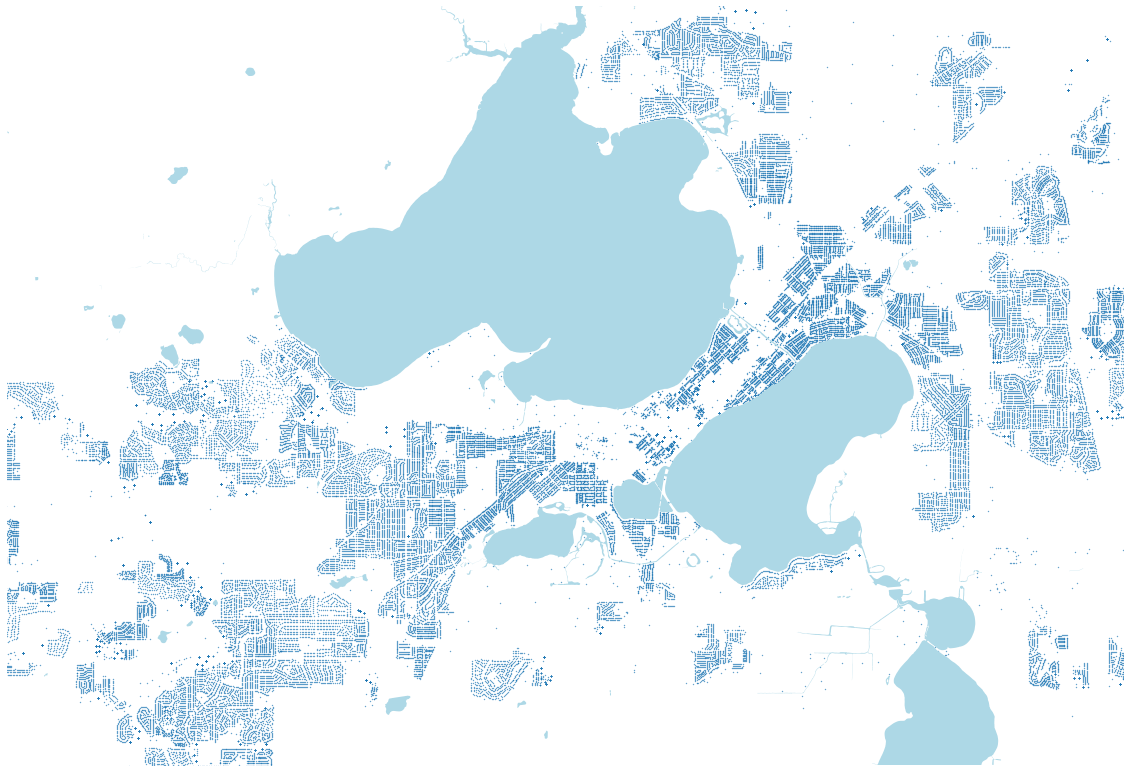

In [23]:
ax = df.plot(markersize=0.1, figsize=(20,20))
lake_df.plot(ax=ax,color="lightblue")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_ylim([43.0125, 43.150])
ax.set_xlim([-89.55, -89.273])
ax.axis('off')

(-89.55, -89.273, 43.0125, 43.15)

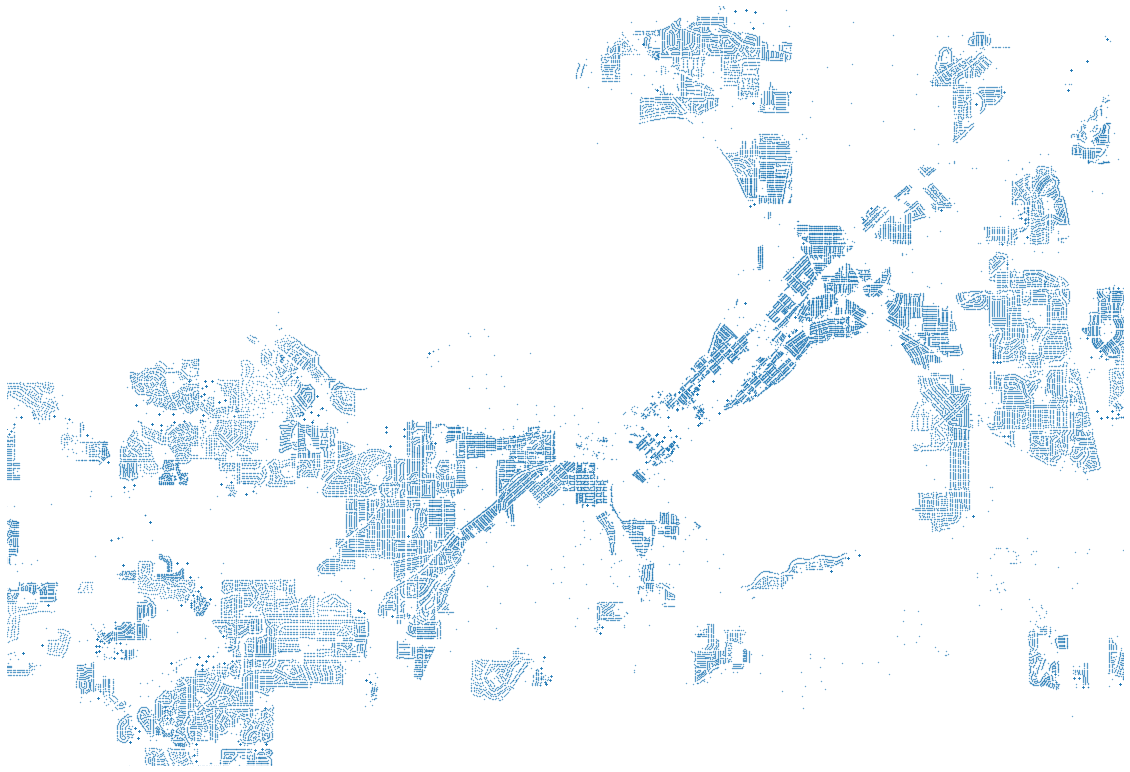

In [24]:
ax = df.plot(markersize=0.1, figsize=(20,20))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_ylim([43.0125, 43.150])
ax.set_xlim([-89.55, -89.273])
ax.axis('off')